# Simple XGBoost Baseline
We train XGB on 2021 targets and predict 2022 targets.

In [1]:
import os
os.environ.setdefault("CUDA_VISIBLE_DEVICES", "7")

VER=8

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

In [3]:
author_features_2021 = pd.read_parquet(f"data/author_features_v8.pqt")
#author_targets_2021 = pd.read_parquet(f"data/author_targets_v8.pqt")

author_features_2022 = pd.read_parquet(f"data/author_features_v2.pqt")
#author_targets_2022 = pd.read_parquet(f"data/author_targets_v2.pqt")

# XGB

In [4]:
#from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
print(f"XGB version: {xgb.__version__}")

XGB version: 3.1.2


In [5]:
TARGET = "target"

FEATURES = [
    # --------------------
    # Collaboration graph
    # --------------------
    "n_coauthors",
    "total_collaborations",
    "avg_collab_strength",
    "max_collab_strength",
    "collab_entropy",

    # --------------------
    # Productivity / recency
    # --------------------
    "total_papers",
    "papers_last_1y",
    "papers_last_3y",
    "days_since_last_paper",

    # --------------------
    # Topic specialization
    # --------------------
    "top_category",          # categorical-as-ordinal (tree-safe)
    "top_category_frac",
    "category_entropy",

    # --------------------
    # Citation impact
    # --------------------
    "total_citations",
    "avg_citations_per_paper",
    "max_citations_single_paper",
    "citations_last_3y",
]

In [6]:
xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.005,
    "max_depth": 6,
    "min_child_weight": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",
    "n_estimators": 10_000,
    "random_state": 42,
    "early_stopping_rounds": 100,
    "device": "cuda",
}

In [7]:
X_train, X_val = author_features_2021[FEATURES], author_features_2022[FEATURES]
y_train, y_val = author_features_2021[TARGET].values, author_features_2022[TARGET].values

model = xgb.XGBClassifier(**xgb_params)
model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=100,
)
oof_preds = model.predict_proba(X_val)[:, 1]

[0]	validation_0-auc:0.71622
[100]	validation_0-auc:0.72506
[200]	validation_0-auc:0.72514
[300]	validation_0-auc:0.72639
[400]	validation_0-auc:0.72687
[500]	validation_0-auc:0.72708
[600]	validation_0-auc:0.72710
[700]	validation_0-auc:0.72724
[800]	validation_0-auc:0.72734
[890]	validation_0-auc:0.72728


/raid/cdeotte/miniconda3/envs/rapids-torch-2/lib/python3.11/site-packages/xgboost/core.py:750: UserWarning: [09:54:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764168035494/work/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [8]:
print("\n==============================")
print("XGB VAL AUC  :", roc_auc_score(y_val, oof_preds))
print("==============================")


XGB VAL AUC  : 0.7273856059900606


In [9]:
# SAVE XGB OOF
np.save(f"data/oof_preds_xgb_v{VER}",oof_preds)

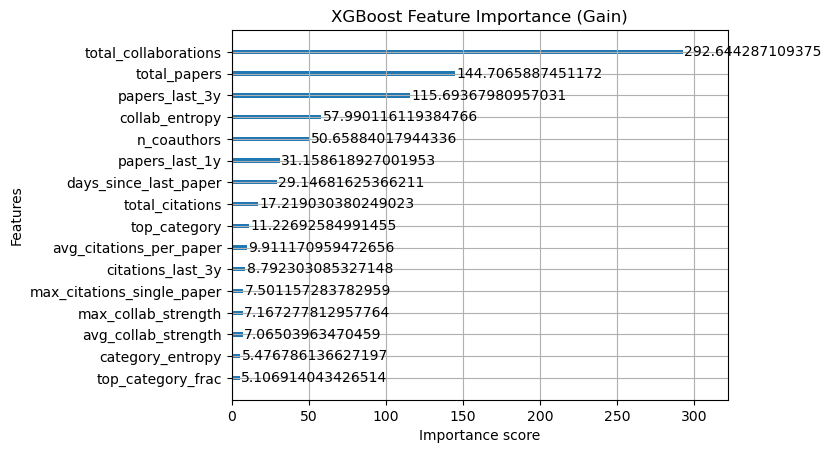

In [10]:
xgb.plot_importance(
    model,
    importance_type="gain",
    max_num_features=20,
)
plt.title("XGBoost Feature Importance (Gain)")
plt.show()